# DN Movie Industry Consulting Firm
**Dmitry Mikhaylov & Ngoc Tran**<br>
Jun 19, 2019

------

### Understand the Movie Industry
Market Penetration Strategy<br>
Key Success Factors: Budget-Genre-Crew

------

**Import**

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

sns.set_style("whitegrid")

------

## First factor:
### Movie budgets analysis

Source: [TheMovieDB.org](https://www.the-numbers.com/movie/budgets/all)

In [2]:
movie_budgets = pd.read_csv("data/tn.movie_budgets.csv.gz")

First, data cleaning

In [3]:
#Define function to convert data to int to do calculations
def money_str_to_int(ms):
    return int(ms.lstrip("$").replace(",", ""))

#Use function above to convert to int
movie_budgets.production_budget = movie_budgets.production_budget.apply(lambda x: money_str_to_int(x))
movie_budgets.domestic_gross = movie_budgets.domestic_gross.apply(lambda x: money_str_to_int(x))
movie_budgets.worldwide_gross = movie_budgets.worldwide_gross.apply(lambda x: money_str_to_int(x))

# Create some additional columns: Ticket_sales, Profit, Profit_margin, Date and P&L_percent
movie_budgets['Ticket_sales'] = (movie_budgets.domestic_gross + movie_budgets.worldwide_gross)
movie_budgets['Profit'] = (movie_budgets.Ticket_sales - movie_budgets.production_budget)
movie_budgets['Profit_margin'] = (movie_budgets.Profit/movie_budgets.production_budget)
movie_budgets['Date'] = movie_budgets['release_date'].astype('datetime64[ns]')
movie_budgets["P&L_percent"] = (movie_budgets.domestic_gross + movie_budgets.worldwide_gross - 
                        movie_budgets.production_budget)/movie_budgets.production_budget

Consider four budget categories:
micro-budget: 0 to 500K, 
low-budget: 500K to 3M, 
big-budget: 3M to 50M,
mega-budget: anything higher

In [4]:
#Define a helper function to break down movie production_budgets into budget subgroups
def get_budget_cat(pb):
    if pb <= 500000:
        return 0
    elif pb <= 3000000:
        return 1
    elif pb <= 50000000:
        return 2
    else:
        return 3

#Apply function defined above
movie_budgets["budget_cat"] = movie_budgets.production_budget.apply(lambda x: get_budget_cat(x))

#Create individual series for respective budget subgroups
micro_budget = movie_budgets[movie_budgets.budget_cat == 0]
low_budget = movie_budgets[movie_budgets.budget_cat == 1]
big_budget = movie_budgets[movie_budgets.budget_cat == 2]
mega_budget = movie_budgets[movie_budgets.budget_cat == 3]

In [5]:
#Create individual series for respective budget categories
micro_budget = movie_budgets[movie_budgets.budget_cat == 0]
low_budget = movie_budgets[movie_budgets.budget_cat == 1]
big_budget = movie_budgets[movie_budgets.budget_cat == 2]
mega_budget = movie_budgets[movie_budgets.budget_cat == 3]

Now we need to look at four different budget subgroups using box plots

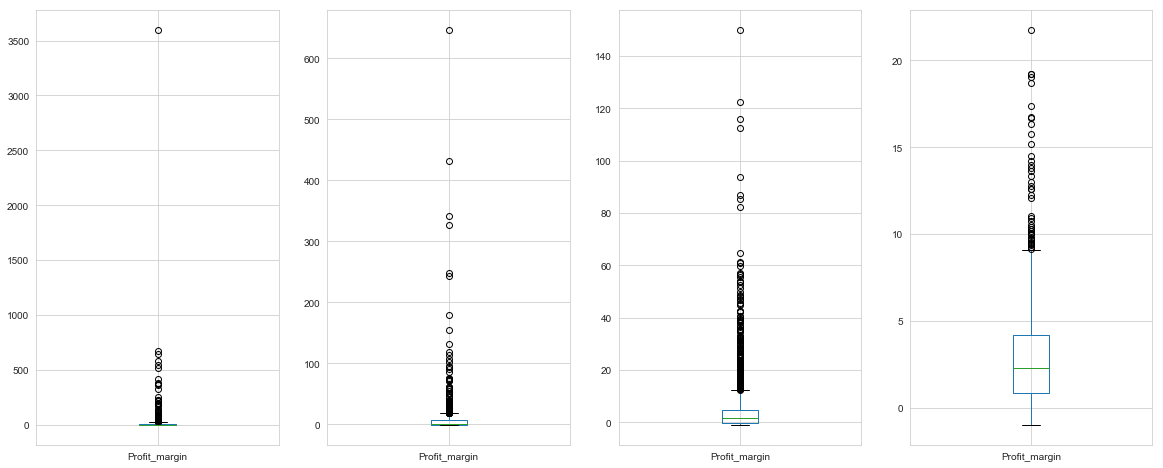

In [6]:
#Create box plots to evaluate central tendency and variations
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(141)
micro_budget["Profit_margin"].plot.box()

ax2 = fig.add_subplot(142)
low_budget["Profit_margin"].plot.box()

ax3 = fig.add_subplot(143)
big_budget["Profit_margin"].plot.box()

ax4 = fig.add_subplot(144)
mega_budget["Profit_margin"].plot.box()

plt.show()

There is way too much variability in these four subgroups thus one needs to remove outliers

In [7]:
movie_budgets_adj = movie_budgets
movie_budgets_adj.describe()

,id,production_budget,domestic_gross,worldwide_gross,Ticket_sales,Profit,Profit_margin,P&L_percent,budget_cat
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000,5782.000000,5782.000000
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,1.333608e+08,1.017730e+08,6.783702,6.783702,1.932203
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,2.399411e+08,2.108880e+08,54.922090,54.922090,0.748108
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.574753e+08,-1.000000,-1.000000,0.000000
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,6.448924e+06,-3.098222e+05,-0.202878,-0.202878,2.000000
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,4.605855e+07,2.499538e+07,1.659315,1.659315,2.000000
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,1.506937e+08,1.111648e+08,4.893170,4.893170,2.000000
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,3.536853e+09,3.111853e+09,3599.000000,3599.000000,3.000000


Drop outliers now and take a high-level view 

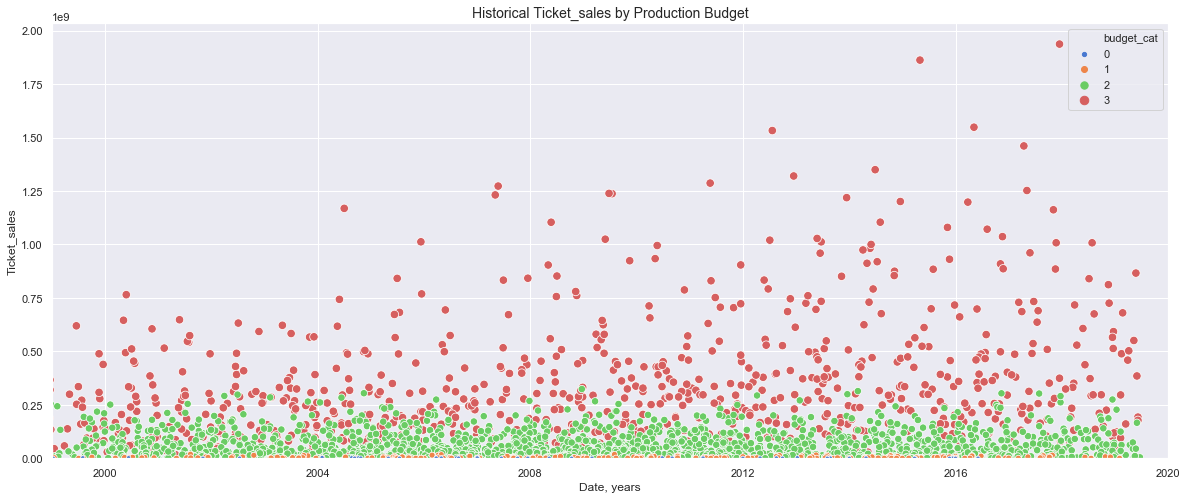

In [8]:
#Drop movies that have domestic sales ==  worldwide sales as this seems to be is bad user input
movie_budgets_adj = movie_budgets_adj.loc[~(movie_budgets_adj.worldwide_gross == movie_budgets_adj.domestic_gross)]

#Drop movies with Profir_margin above 75% (4th Quartile), this will still capture outstanding P&Ls of more than 500% profit
movie_budgets_adj = movie_budgets_adj.loc[~(movie_budgets_adj['Profit_margin'] > 5.5)]

#Plot to check historical evolution of Ticket_sales
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Historical Ticket_sales by Production Budget', fontsize = 14)
sns.scatterplot(x=movie_budgets_adj.Date.tolist(), y=(movie_budgets_adj['Ticket_sales']), 
                hue = movie_budgets_adj['budget_cat'], palette=sns.color_palette("muted")[:4], 
                size = movie_budgets_adj['budget_cat'])

#Date can go back to 1936, thus drop all till 1999
plt.xlim(datetime(1999, 1, 1), datetime(2020, 1, 1))
plt.ylim(0.00, None)
plt.xlabel('Date, years')
plt.show()

Check distribution of profits: how many movies are making vs losing money  

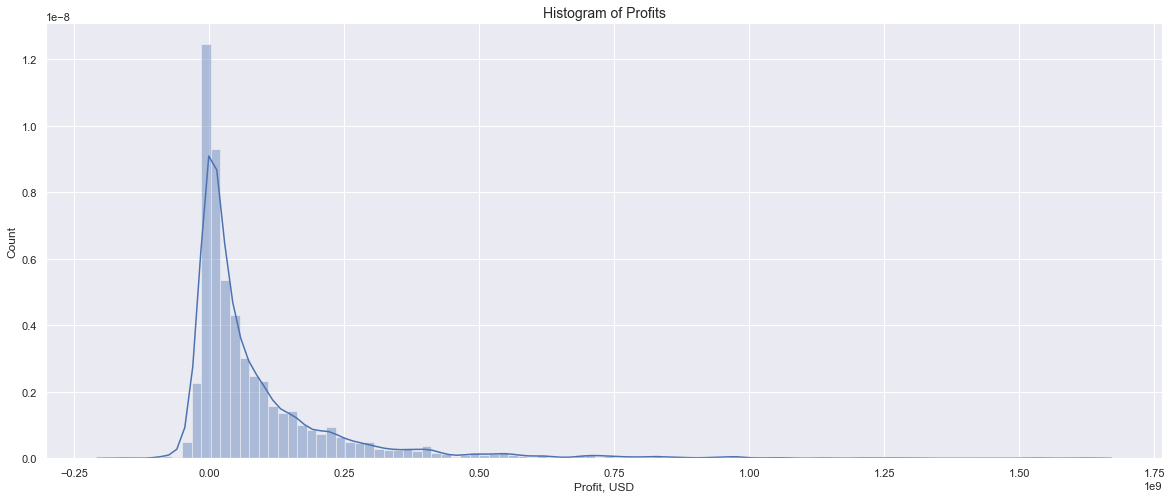

In [9]:
#Plot to check approximate distribution of Profits
sns.distplot(movie_budgets_adj['Profit'], bins = 100) 
#sns.distplot(movie_budgets_adj['Profit_margin'], bins = 100) 
plt.title('Histogram of Profits', fontsize = 14)
plt.ylabel('Count')
plt.xlabel('Profit, USD')
plt.show()

Repeat box plot charts on adjusted observations

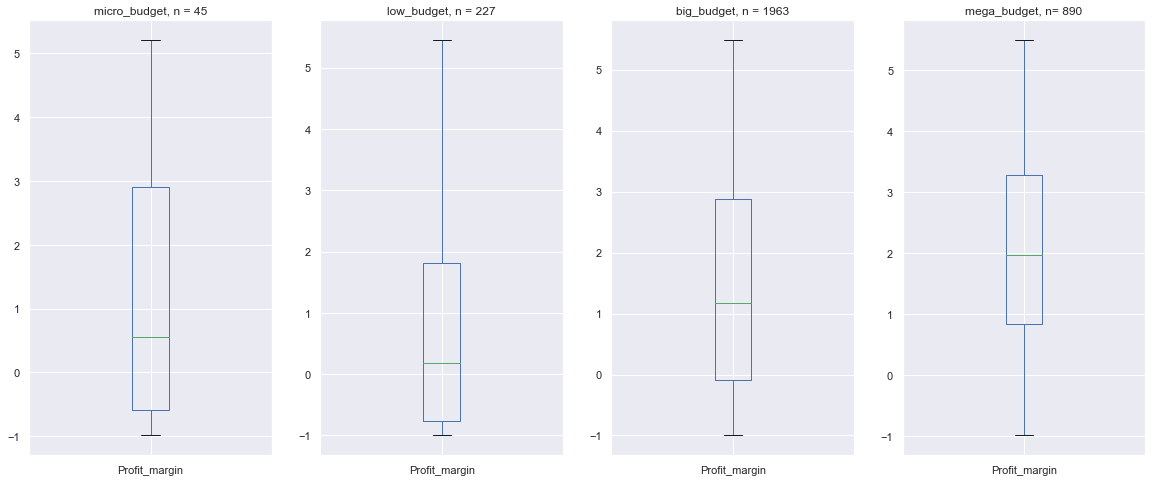

In [10]:
#Rerun box plots on budget categories
micro_budget_adj = movie_budgets_adj[movie_budgets_adj.budget_cat == 0]
low_budget_adj = movie_budgets_adj[movie_budgets_adj.budget_cat == 1]
big_budget_adj = movie_budgets_adj[movie_budgets_adj.budget_cat == 2]
mega_budget_adj = movie_budgets_adj[movie_budgets_adj.budget_cat == 3]

#Define and plot box plot charts
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(141)
micro_budget_adj["Profit_margin"].plot.box(title='micro_budget, n = 45')

ax2 = fig.add_subplot(142)
low_budget_adj["Profit_margin"].plot.box(title='low_budget, n = 227')

ax3 = fig.add_subplot(143)
big_budget_adj["Profit_margin"].plot.box(title='big_budget, n = 1963')

ax4 = fig.add_subplot(144)
mega_budget_adj["Profit_margin"].plot.box(title='mega_budget, n= 890')

plt.show()

**Conclusion:** Micro-budgets, although tend to break even, will not likely cover overhead. Low-budget movies are very risky and tend to lose money. Mega-budgets seem to have very high volatility and are associated with large value investments. Therefore, we elect to focus on moderate, middle-of-the-road, $3M-50M budget group.

## Second factor:
### Genres analysis

**The first data set**

Source: [IMDB](https://www.imdb.com/interfaces/)

In [11]:
title_basics = pd.read_csv("data/imdb.title.basics.csv.gz")

Check it out

In [12]:
title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
tconst             146144 non-null object
primary_title      146144 non-null object
original_title     146123 non-null object
start_year         146144 non-null int64
runtime_minutes    114405 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Duplicates

In [13]:
title_basics[title_basics.duplicated()]

,tconst,primary_title,original_title,start_year,runtime_minutes,genres


Missing values

In [14]:
title_basics["genres"].isna().sum() / len(title_basics) * 100

3.7004598204510617

Right now, we only care about tconst (PK) and genres

In [15]:
title_basics.drop(columns=["primary_title", "original_title", "start_year", "runtime_minutes"], inplace=True)

How many genres are there?

In [16]:
genres = []
for i in range(len(title_basics)):
    if type(title_basics.genres[i]) == str:
        gen = title_basics.genres[i].split(",")
        for g in gen:
            if g not in genres:
                genres.append(g)

In [17]:
print(len(genres))
genres

27


['Action',
 'Crime',
 'Drama',
 'Biography',
 'Comedy',
 'Fantasy',
 'Horror',
 'Thriller',
 'Adventure',
 'Animation',
 'Documentary',
 'History',
 'Mystery',
 'Sci-Fi',
 'Romance',
 'Family',
 'War',
 'Music',
 'Sport',
 'Western',
 'Musical',
 'Adult',
 'News',
 'Talk-Show',
 'Reality-TV',
 'Game-Show',
 'Short']

Create columns for those genres

In [18]:
action = []
crime = []
drama = []
biography = []
comedy = []
fantasy = []
horror = []
thriller = []
adventure = []
animation = []
documentary = []
history = []
mystery = []
scifi = []
romance = []
family = []
war = []
music = []
sport = []
western = []
musical = []
adult = []
news = []
talk_show = []
reality_TV = []
game_show = []
short = []

list_genres = [action, crime, drama, biography, comedy, fantasy, horror, thriller, adventure, animation,
               documentary, history, mystery, scifi, romance, family, war, music, sport, western, musical,
               adult, news, talk_show, reality_TV, game_show, short]

list_genres_names = ["action", "crime", "drama", "biography", "comedy", "fantasy", "horror", "thriller",
                     "adventure", "animation", "documentary", "history", "mystery", "scifi", "romance",
                     "family", "war", "music", "sport", "western", "musical", "adult", "news", "talk_show",
                     "reality_TV", "game_show", "short"]

In [19]:
def give_one(list_genres, index):
    list_genres[index].append(1)

In [20]:
def give_zeros(list_genres, list_i):
    for i in range(27):
        if i not in list_i:
            list_genres[i].append(0)

In [21]:
def fill_all_zeros(list_genres):
    for i in range(27):
        list_genres[i].append(0)

In [22]:
for i in range(len(title_basics)):
    if type(title_basics.genres[i]) == str:
        gen = title_basics.genres[i].split(",")
        list_i = []
        for g in gen:
            g = g.lower()
            if g == "sci-fi":
                g = "scifi"
            elif g == "talk-show":
                g = "talk_show"
            elif g == "reality-tv":
                g = "reality_TV"
            elif g == "game-show":
                g = "game_show"
            index = list_genres_names.index(g)
            give_one(list_genres, index)
            list_i.append(index)
        give_zeros(list_genres, list_i)
    else:
        fill_all_zeros(list_genres)

In [23]:
title_basics["action"] = action
title_basics["crime"] = crime
title_basics["drama"] = drama
title_basics["biography"] = biography
title_basics["comedy"] = comedy
title_basics["fantasy"] = fantasy
title_basics["horror"] = horror
title_basics["thriller"] = thriller
title_basics["adventure"] = adventure
title_basics["animation"] = animation
title_basics["documentary"] = documentary
title_basics["history"] = history
title_basics["mystery"] = mystery
title_basics["scifi"] = scifi
title_basics["romance"] = romance
title_basics["family"] = family
title_basics["war"] = war
title_basics["music"] = music
title_basics["sport"] = sport
title_basics["western"] = western
title_basics["musical"] = musical
title_basics["adult"] = adult
title_basics["news"] = news
title_basics["talk_show"] = talk_show
title_basics["reality_TV"] = reality_TV
title_basics["game_show"] = game_show
title_basics["short"] = short

We don't need the genres column anymore

In [24]:
title_basics.drop(columns="genres", inplace=True)

Let's look at the data frame

In [25]:
title_basics.head()

,tconst,action,crime,drama,biography,comedy,fantasy,horror,thriller,adventure,...,music,sport,western,musical,adult,news,talk_show,reality_TV,game_show,short
0,tt0063540,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0069204,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0100275,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**The second data set**

Source: [IMDB](https://www.imdb.com/interfaces/)

In [26]:
title_ratings = pd.read_csv("data/imdb.title.ratings.csv.gz")

Check it out

In [27]:
title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [28]:
title_ratings.describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


We only care about the average rating

In [29]:
title_ratings.drop(columns="numvotes", inplace=True)

Let's look at the data frame

In [30]:
title_ratings.head()

,tconst,averagerating
0,tt10356526,8.3
1,tt10384606,8.9
2,tt1042974,6.4
3,tt1043726,4.2
4,tt1060240,6.5


**Merging the two data frames**

In [31]:
df = title_basics.merge(title_ratings, how='inner', on="tconst")

Check it out

In [32]:
df.head()

,tconst,action,crime,drama,biography,comedy,fantasy,horror,thriller,adventure,...,sport,western,musical,adult,news,talk_show,reality_TV,game_show,short,averagerating
0,tt0063540,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
1,tt0066787,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.2
2,tt0069049,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.9
3,tt0069204,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.1
4,tt0100275,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6.5


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 29 columns):
tconst           73856 non-null object
action           73856 non-null int64
crime            73856 non-null int64
drama            73856 non-null int64
biography        73856 non-null int64
comedy           73856 non-null int64
fantasy          73856 non-null int64
horror           73856 non-null int64
thriller         73856 non-null int64
adventure        73856 non-null int64
animation        73856 non-null int64
documentary      73856 non-null int64
history          73856 non-null int64
mystery          73856 non-null int64
scifi            73856 non-null int64
romance          73856 non-null int64
family           73856 non-null int64
war              73856 non-null int64
music            73856 non-null int64
sport            73856 non-null int64
western          73856 non-null int64
musical          73856 non-null int64
adult            73856 non-null int64
news            

**Getting down to business**

In [34]:
action_movies = df[df.action == 1]
crime_movies = df[df.crime == 1]
drama_movies = df[df.drama == 1]
biography_movies = df[df.biography == 1]
comedy_movies = df[df.comedy == 1]
fantasy_movies = df[df.fantasy == 1]
horror_movies = df[df.horror == 1]
thriller_movies = df[df.thriller == 1]
adventure_movies = df[df.adventure == 1]
animation_movies = df[df.animation == 1]
documentary_movies = df[df.documentary == 1]
history_movies = df[df.history == 1]
mystery_movies = df[df.mystery == 1]
scifi_movies = df[df.scifi == 1]
romance_movies = df[df.romance == 1]
family_movies = df[df.family == 1]
war_movies = df[df.war == 1]
music_movies = df[df.music == 1]
sport_movies = df[df.sport == 1]
western_movies = df[df.western == 1]
musical_movies = df[df.musical == 1]
adult_movies = df[df.adult == 1]
news_movies = df[df.news == 1]
talk_show_movies = df[df.talk_show == 1]
reality_TV_movies = df[df.reality_TV == 1]
game_show_movies = df[df.game_show == 1]
short_movies = df[df.short == 1]

Note: We're not dealing with adult movies (3 samples), talk shows (0 sample), reality TV's (17 samples), game shows (2 samples), and short movies (1 sample) due to not having enough data in those categories.

In [35]:
list_movies = [action_movies, crime_movies, drama_movies, biography_movies, comedy_movies, fantasy_movies,
               horror_movies, thriller_movies, adventure_movies, animation_movies, documentary_movies,
               history_movies, mystery_movies, scifi_movies, romance_movies, family_movies, war_movies,
               music_movies, sport_movies, western_movies, musical_movies, news_movies]

list_genres_names_new = ["action", "crime", "drama", "biography", "comedy", "fantasy", "horror", "thriller",
                         "adventure", "animation", "documentary", "history", "mystery", "scifi", "romance",
                         "family", "war", "music", "sport", "western", "musical", "news"]

Find the means of different genres' average ratings

In [36]:
list_movies_ave_rate_mean = [action_movies.averagerating.mean(), crime_movies.averagerating.mean(),
                             drama_movies.averagerating.mean(), biography_movies.averagerating.mean(),
                             comedy_movies.averagerating.mean(), fantasy_movies.averagerating.mean(),
                             horror_movies.averagerating.mean(), thriller_movies.averagerating.mean(),
                             adventure_movies.averagerating.mean(), animation_movies.averagerating.mean(),
                             documentary_movies.averagerating.mean(), history_movies.averagerating.mean(),
                             mystery_movies.averagerating.mean(), scifi_movies.averagerating.mean(),
                             romance_movies.averagerating.mean(), family_movies.averagerating.mean(),
                             war_movies.averagerating.mean(), music_movies.averagerating.mean(),
                             sport_movies.averagerating.mean(), western_movies.averagerating.mean(),
                             musical_movies.averagerating.mean(), news_movies.averagerating.mean()]

zipped_pairs = list(zip(list_movies_ave_rate_mean, list_genres_names_new))
zipped_pairs.sort(reverse=True)
names_mean = []
list_mean = []
for i in zipped_pairs:
    list_mean.append(i[0])
    names_mean.append(i[1])

Find the variances of different genres' average ratings

In [37]:
list_movies_ave_rate_variance = [action_movies.averagerating.var(), crime_movies.averagerating.var(),
                                 drama_movies.averagerating.var(), biography_movies.averagerating.var(),
                                 comedy_movies.averagerating.var(), fantasy_movies.averagerating.var(),
                                 horror_movies.averagerating.var(), thriller_movies.averagerating.var(),
                                 adventure_movies.averagerating.var(), animation_movies.averagerating.var(),
                                 documentary_movies.averagerating.var(), history_movies.averagerating.var(),
                                 mystery_movies.averagerating.var(), scifi_movies.averagerating.var(),
                                 romance_movies.averagerating.var(), family_movies.averagerating.var(),
                                 war_movies.averagerating.var(), music_movies.averagerating.var(),
                                 sport_movies.averagerating.var(), western_movies.averagerating.var(),
                                 musical_movies.averagerating.var(), news_movies.averagerating.var()]

zipped_pairs = list(zip(list_movies_ave_rate_variance, list_genres_names_new))
zipped_pairs.sort()
names_var = []
list_var = []
for i in zipped_pairs:
    list_var.append(i[0])
    names_var.append(i[1])

Plot bar plots of means and variances

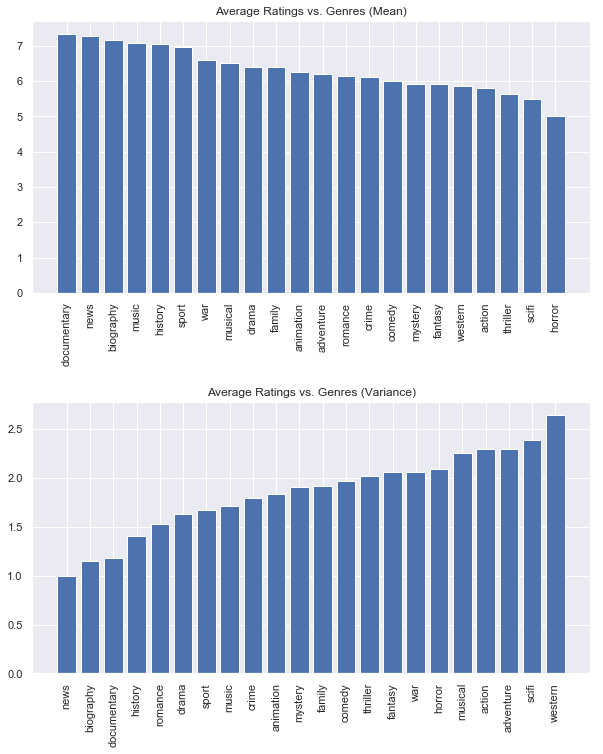

In [38]:
fig = plt.figure(figsize=(10,12))

ax = fig.add_subplot(211)
ax.set_xticks(range(22))
ax.set_xticklabels(names_mean, rotation="vertical")
plt.bar(range(22), list_mean)
ax.set_title("Average Ratings vs. Genres (Mean)")

ax = fig.add_subplot(212)
ax.set_xticks(range(22))
ax.set_xticklabels(names_var, rotation="vertical")
plt.bar(range(22), list_var)
ax.set_title("Average Ratings vs. Genres (Variance)")

plt.subplots_adjust(hspace=0.4)

plt.show()

Plot final chart providing actionable insight

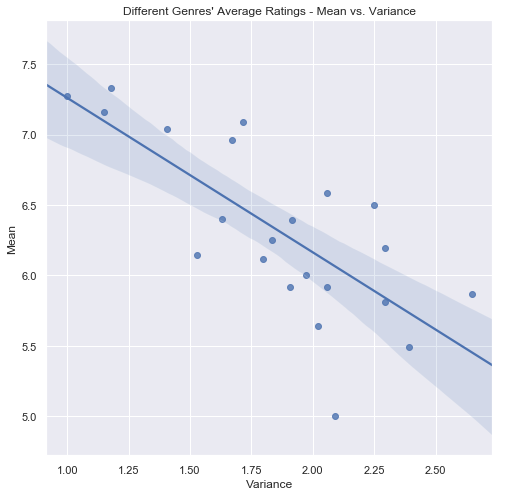

In [39]:
fig = plt.figure(figsize=(8,8))
sns.regplot(list_movies_ave_rate_variance, list_movies_ave_rate_mean);
plt.title("Different Genres' Average Ratings - Mean vs. Variance");
plt.xlabel("Variance");
plt.ylabel("Mean");

**Conclusion:** The points at the top left of the graph represent the genres that have stable and high average ratings. Those genres are: news, biography, documentary, and history. Interestingly, they all focus on (hopefully) facts. We should focus on these genres.

------------------

## Third factor:
### Crew analysis

**The first data set**

Source: [IMDB](https://www.imdb.com/interfaces/)

In [40]:
title_principals = pd.read_csv("data/imdb.title.principals.csv.gz")

Check it out

In [41]:
title_principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
tconst        1028186 non-null object
ordering      1028186 non-null int64
nconst        1028186 non-null object
category      1028186 non-null object
job           177684 non-null object
characters    393360 non-null object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


We don't need the ordering, job, and characters columns

In [42]:
title_principals.drop(columns=["ordering", "job", "characters"], inplace=True)

Let's look at the data frame

In [43]:
title_principals.head()

,tconst,nconst,category
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress


**The second data set**

Source: [IMDB](https://www.imdb.com/interfaces/)

In [44]:
title_ratings = pd.read_csv("data/imdb.title.ratings.csv.gz")

Check it out

In [45]:
title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


We don't need the numvotes columns

In [46]:
title_ratings.drop(columns="numvotes", inplace=True)

Let's look at the data frame

In [47]:
title_ratings.head()

,tconst,averagerating
0,tt10356526,8.3
1,tt10384606,8.9
2,tt1042974,6.4
3,tt1043726,4.2
4,tt1060240,6.5


**Merging the two data frames**

In [48]:
df = title_principals.merge(title_ratings, on="tconst", how="inner")

Check it out

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629755 entries, 0 to 629754
Data columns (total 4 columns):
tconst           629755 non-null object
nconst           629755 non-null object
category         629755 non-null object
averagerating    629755 non-null float64
dtypes: float64(1), object(3)
memory usage: 24.0+ MB


In [50]:
df[df.duplicated()]

,tconst,nconst,category,averagerating
9562,tt2073120,nm1794850,actor,7.0
112399,tt2258513,nm3206691,actor,7.0
158948,tt2368182,nm3772098,actor,6.1
254979,tt3503838,nm3895623,actress,5.1
307463,tt3246048,nm5992239,actress,7.4
329694,tt3153648,nm1289422,actress,7.6
368412,tt2473710,nm5241644,actor,6.9
439819,tt5473578,nm0149828,actress,5.0
445896,tt6094992,nm8204953,producer,5.2
468618,tt6549064,nm0244327,actress,4.5


Let's look at the data frame

In [51]:
df.head()

,tconst,nconst,category,averagerating
0,tt0323808,nm0059247,editor,3.9
1,tt0323808,nm3579312,actress,3.9
2,tt0323808,nm2694680,actor,3.9
3,tt0323808,nm0574615,actor,3.9
4,tt0323808,nm0502652,actress,3.9


**The third data set**

Source: [IMDB](https://www.imdb.com/interfaces/)

In [52]:
name_basics = pd.read_csv("data/imdb.name.basics.csv.gz")

Check it out

In [53]:
name_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
nconst                606648 non-null object
primary_name          606648 non-null object
birth_year            82736 non-null float64
death_year            6783 non-null float64
primary_profession    555308 non-null object
known_for_titles      576444 non-null object
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


In [54]:
name_basics.death_year.isna().sum()

599865

In [55]:
name_basics.death_year.isna().sum() / len(name_basics) * 100

98.88188867349764

We don't want the people that have already passed. Can't hire them...

In [56]:
name_basics = name_basics[name_basics.death_year.isna()]

We just need the names

In [57]:
name_basics.drop(columns=["birth_year", "death_year", "primary_profession", "known_for_titles"], inplace=True)

Let's look at the data frame

In [58]:
name_basics.head()

,nconst,primary_name
0,nm0061671,Mary Ellen Bauder
1,nm0061865,Joseph Bauer
2,nm0062070,Bruce Baum
3,nm0062195,Axel Baumann
4,nm0062798,Pete Baxter


**More merging**

In [59]:
df = df.merge(name_basics, on="nconst", how="inner")

Check it out

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621366 entries, 0 to 621365
Data columns (total 5 columns):
tconst           621366 non-null object
nconst           621366 non-null object
category         621366 non-null object
averagerating    621366 non-null float64
primary_name     621366 non-null object
dtypes: float64(1), object(4)
memory usage: 28.4+ MB


In [61]:
df[df.duplicated()]

,tconst,nconst,category,averagerating,primary_name
38723,tt2073120,nm1794850,actor,7.0,David Chalmers
118859,tt6664852,nm0605583,actor,6.6,Robert Morin
180018,tt3503838,nm3895623,actress,5.1,Jacqueline Chong
180024,tt6423408,nm3895623,actress,3.9,Jacqueline Chong
187643,tt4537170,nm0172826,actor,7.0,Luigi Cozzi
247929,tt2258513,nm3206691,actor,7.0,Hasan Majuni
255412,tt6549064,nm0244327,actress,4.5,Dorra Zarrouk
302130,tt2368182,nm3772098,actor,6.1,Ross Everett
344691,tt8942260,nm2442121,actress,6.1,Ivy Yi-Han Chen
412852,tt8108180,nm0849468,actor,7.7,Masashi Taniguchi


Let's look at the data frame

In [62]:
df.head()

,tconst,nconst,category,averagerating,primary_name
0,tt0323808,nm0059247,editor,3.9,Sean Barton
1,tt2081348,nm0059247,editor,4.1,Sean Barton
2,tt1414378,nm0059247,editor,6.5,Sean Barton
3,tt2712990,nm0059247,editor,5.6,Sean Barton
4,tt2395207,nm0059247,editor,5.5,Sean Barton


**Getting down to business**

We want to hire those who can potentially help us make movies that have good ratings<br>
Let's have high standard! A good movie should have an average rating of at least 8

In [63]:
df_good_rating = df[df.averagerating >= 8]

We will only focus on actors, actresses, directors, and writers

In [64]:
df_good_rating_cat = df_good_rating.groupby("category")

In [65]:
good_actors = list(df_good_rating_cat.get_group("actor").primary_name)
good_actors = list(set(good_actors))

In [66]:
good_actresses = list(df_good_rating_cat.get_group("actress").primary_name)
good_actresses = list(set(good_actresses))

In [67]:
good_directors = list(df_good_rating_cat.get_group("director").primary_name)
good_directors = list(set(good_directors))

In [68]:
good_writers = list(df_good_rating_cat.get_group("writer").primary_name)
good_writers = list(set(good_writers))

**Whom should we hire?**

At this point, we have ourselves a list of good actors, a list of good actresses, a list of good directors, and a list of good writers. However, are they really good? Or are they just lucky?<br>
Let us only consider hiring those who are consistenly sucessful.<br>
More than 5 projects per portfolio is decent?!

In [69]:
df_people = df.groupby("primary_name")

In [70]:
good_actors_new = []
for person in good_actors:
    if len(df_people.get_group(person)) > 5 and df_people.get_group(person).averagerating.mean() >= 8:
        good_actors_new.append(person)

In [71]:
good_actresses_new = []
for person in good_actresses:
    if len(df_people.get_group(person)) > 5 and df_people.get_group(person).averagerating.mean() >= 8:
        good_actresses_new.append(person)

In [72]:
good_directors_new = []
for person in good_directors:
    if len(df_people.get_group(person)) > 5 and df_people.get_group(person).averagerating.mean() >= 8:
        good_directors_new.append(person)

In [73]:
good_writers_new = []
for person in good_writers:
    if len(df_people.get_group(person)) > 5 and df_people.get_group(person).averagerating.mean() >= 8:
        good_writers_new.append(person)

And the winners are

In [74]:
df_hire = pd.DataFrame([good_actors_new, good_actresses_new, good_directors_new, good_writers_new])
df_hire = df_hire.T
df_hire.columns = ["Actors", "Actresses", "Directors", "Writers"]
df_hire

,Actors,Actresses,Directors,Writers
0,David Anghel,CC King,Dick Carruthers,Matt Lang
1,Ian Cranston,Susan Brown,Ian Cranston,David Anghel
2,Alvaro Calderón,Jayani Senanayake,Michael Henry,Alvaro Calderón
3,Michael Henry,Lauren Lopez,Brian Holden,Darren Wilson
4,Michael Fleming,Sylvia Earle,Carlos Nader,Brian Holden
5,Joshua Bell,Sargun Mehta,Peter Mortimer,Eric Frith
6,Thom Keller,Lelani Mitchem,Mat Hames,Nick Rosen
7,Thumindu Dodantenne,None,Nabwana I.G.G.,None
8,Kalyan Chatterjee,None,Andrew Swant,None
9,Darren Wilson,None,Christopher Kenneally,None
